# Initial model building with all parameters

Trying to do density-based clustering

In [62]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt




In [101]:
crmData

,Material,EOLR,SR,EI,Stage used in SR
0,Aggregates,0.09,0.2,3.2,E
1,HREE,0.01,5.1,4.2,P
2,Phosphorus,0.00,3.3,4.7,P
3,Hydrogen,0.00,0.5,2.9,E
4,Potash,0.00,0.7,6.2,E
...,...,...,...,...,...
67,Palladium,0.12,2.7,7.1,P
68,Zinc,0.34,0.2,4.8,E
69,Helium,0.02,1.2,2.9,P
70,Phosphate_rock,0.00,1.0,6.4,E


In [141]:
compData = pd.read_csv('../CRM data/compData.csv',sep=',')
crmData = pd.read_csv('../CRM data/full_data.csv',sep=',')

In [103]:
model = crmData[(crmData['SR']>=1.0) &(crmData['EI']>=1.0)]
model = model[['Material','EOLR','SR','EI']]
model.loc[:,'EOLR'] = model['EOLR']
numCols = ['EOLR','SR','EI']
scaler = MinMaxScaler()
model.loc[:,numCols] = scaler.fit_transform(model[numCols])

In [142]:
model = compData[['Material','aEHP','EGov','GSMEF','EOLR','SR','EI']]
model = compData[(compData['SR']>=1.0) &(compData['EI']>=1.0)]
numCols = ['EOLR','SR','EI']
scaler = MinMaxScaler()
model.loc[:,numCols] = scaler.fit_transform(model[numCols])

In [143]:
dbscan = DBSCAN(eps=0.25, min_samples=3)
model['Cluster'] = dbscan.fit_predict(model[numCols])
print(model['Cluster'].value_counts())


Cluster
-1    11
 1     5
 0     3
Name: count, dtype: int64


/var/folders/2m/gtf4m1p90_71kcm63w5hnfj00000gn/T/ipykernel_16127/895554164.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [150]:
crit = model[(model['Cluster']==-1) | (model['Cluster']==0)]
critFilter = compData[compData['Material'].isin(crit['Material'])]

notcrit = model[(model['Cluster']==1)]
notcritFilt = compData[compData['Material'].isin(notcrit['Material'])]

In [105]:
epsVal = np.arange(0.05,0.6,0.02)
samples = [i for i in range(1,20,1)]

best_score = -1
best_eps = None
best_min_samples = None

# Loop through different combinations of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(model[numCols])
        
        # Avoid silhouette score calculation when all points are noise (-1)
        if len(set(clusters)) > 1:  # More than 1 unique cluster (excluding noise)
            score = silhouette_score(model[numCols], clusters)
            #print(f"eps: {eps}, min_samples: {min_samples}, Silhouette Score: {score}")
            
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Best parameters: eps = {best_eps}, min_samples = {best_min_samples}, with Silhouette Score: {best_score}")

Best parameters: eps = 0.3, min_samples = 5, with Silhouette Score: 0.4164032213322082


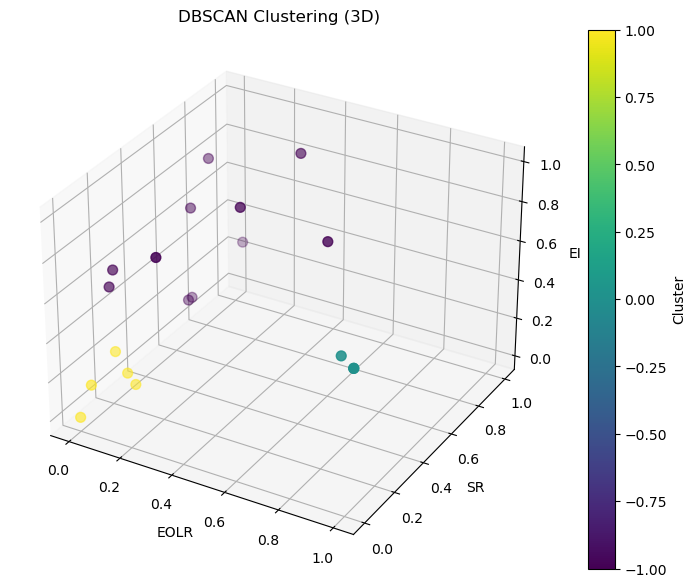

In [123]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')  # No need to explicitly import Axes3D

# Select the columns for 3D scatter plot
x = model['EOLR']  # X-axis (EOLR)
y = model['SR']    # Y-axis (SR)
z = model['EI']    # Z-axis (EI)

# Scatter plot with cluster color coding
sc = ax.scatter(x, y, z, c=model['Cluster'], cmap='viridis', s=50)

# Adding titles and labels
ax.set_title('DBSCAN Clustering (3D)')
ax.set_xlabel('EOLR')
ax.set_ylabel('SR')
ax.set_zlabel('EI')

# Colorbar for clusters
plt.colorbar(sc, label='Cluster')

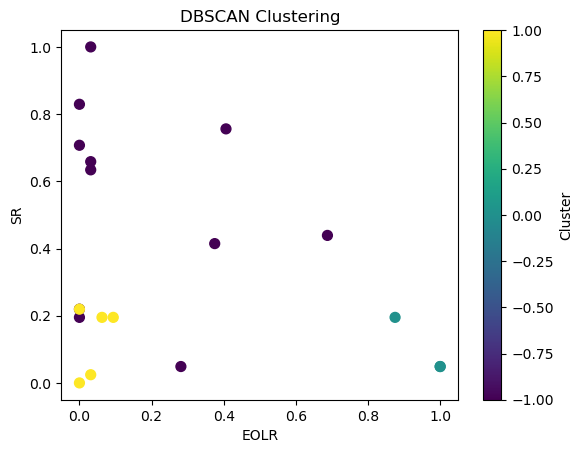

In [122]:
plt.scatter(model['EOLR'], model['SR'], c=model['Cluster'], cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('EOLR')
plt.ylabel('SR')
plt.colorbar(label='Cluster')
plt.show()

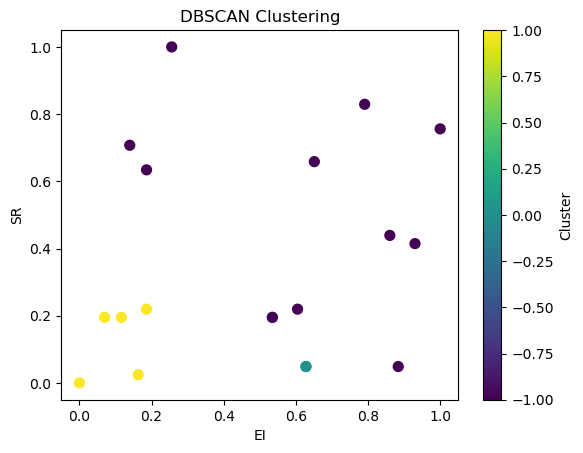

In [121]:
plt.scatter(model['EI'], model['SR'], c=model['Cluster'], cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('EI')
plt.ylabel('SR')
plt.colorbar(label='Cluster')
plt.show()